In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms

In [65]:
class UNETT(nn.Module):
    def __init__(self):
        super().__init__()
        self.enc_l1_conv1 = nn.Conv2d(3,64,(7,7),stride=2,padding=3)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.enc_l2_conv1 = nn.Conv2d(64,64,(3,3),stride=2,padding=1)
        self.enc_l2_conv2 = nn.Conv2d(64,64,(3,3),stride=1,padding=1)
        self.enc_l3_conv1 = nn.Conv2d(64,128,(3,3),stride=2,padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.enc_l3_conv2 = nn.Conv2d(128,128,(3,3),stride=1,padding=1)
        self.enc_
    def forward(self,im):  #im_size = 3*512*512
        im_e_l1 = self.relu(self.bn1(self.enc_l1_conv1(im)))   #(64,256,256)
        im_e_l2_skip = self.relu(self.bn1(self.enc_l2_conv1(im_e_l1)))    #(64,128,128)
        im_e_l2 = self.relu(im_e_l2_skip + self.bn1(self.enc_l2_conv2(self.relu(self.bn1(self.enc_l2_conv2(im_e_l2_skip)))))) #(64,128,128)
        im_e_l3_skip = self.enc_l3_conv1(im_e_l2) #(128,64,64)
        im_e_l3_1 = self.relu(self.bn2(self.enc_l3_conv2(im_e_l3_skip)))
        im_e_l3_2 = self.relu(self.bn2(self.enc_l3_conv2(im_e_l3_1)))
        im_e_l3 = self.relu(im_e_l3_skip + self.bn2(self.enc_l3_conv2(im_e_l3_skip)))
        print((self.relu(self.bn2(self.enc_l3_conv2(im_e_l3_skip)))).shape)
        #print((self.relu(self.bn1(self.enc_l2_conv2(im_e_l2_skip)))).shape)
        print(im_e_l3.shape)
        

In [2]:
enc_l2_res_block_downsampling = nn.Sequential(
    nn.Conv2d(64,64,(3,3),stride=2,padding=1),
    nn.BatchNorm2d(64),
    nn.ReLU()
)

In [3]:
enc_l2_res_basic_block = nn.Sequential(
    nn.Conv2d(64,64,(3,3),padding=1),
    nn.BatchNorm2d(64)
)

In [4]:
enc_l3_res_block_downsampling = nn.Sequential(
    nn.Conv2d(64,128,(3,3),stride=2,padding=1),
    nn.BatchNorm2d(128),
    nn.ReLU()
)

In [5]:
class res_block_downsampling(nn.Module):
    def __init__(self,in_channels,out_channels):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels,in_channels,(3,3),padding=1)
        self.bn1 = nn.BatchNorm2d(in_channels)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv2d(in_channels,out_channels,(3,3),stride=2,padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.skip_conv = nn.Conv2d(in_channels,out_channels,(1,1),stride=2)
    def forward(self,inp):
        out1 = self.relu(self.bn1(self.conv1(inp)))
        out2 = self.bn2(self.conv2(out1))
        skip = self.bn2(self.skip_conv(inp))
        return self.relu(out2+skip)
        

In [6]:
class residual_basic_block(nn.Module):
    def __init__(self,in_channels,out_channels):
        super().__init__()
        self.conv = nn.Conv2d(in_channels,out_channels,(3,3),padding=1)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
    def forward(self,inp):
        out1 = self.relu(self.bn(self.conv(inp)))
        return self.relu(self.bn(self.conv(out1)) + inp)

In [7]:
class double_conv(nn.Module):
    def __init__(self,in_channels,out_channels):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels,out_channels,(3,3),padding=1)
        self.relu = nn.ReLU()
        self.bn = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels,out_channels,(3,3),padding=1)
    def forward(self,inp):
        return self.relu(self.bn(self.conv2(self.relu(self.bn(self.conv1(inp))))))

In [8]:
class dec_head(nn.Module):
    def __init__(self,in_channels,out_channels):
        super().__init__()
        self.conv = nn.Conv2d(in_channels,out_channels,(1,1))
        #
    def forward(self,inp):
        return F.softmax(self.conv(inp),dim=1)

In [9]:
class UNET(nn.Module):
    def __init__(self):
        super().__init__()
        self.enc_l1_conv = nn.Conv2d(3,64,(7,7),stride=2,padding=3)
        self.bn_64 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.res_block_downsample_l2 = res_block_downsampling(64,64)
        self.residual_basic_block_l2 = residual_basic_block(64,64)
        self.res_block_downsample_l3 = res_block_downsampling(64,128)
        self.res_basic_block_l3 = residual_basic_block(128,128)
        self.res_block_downsample_l4 = res_block_downsampling(128,256)
        self.res_basic_block_l4 = residual_basic_block(256,256)
        self.res_block_downsample_l5 = res_block_downsampling(256,512)
        self.res_basic_block_l5 = residual_basic_block(512,512)
        self.upsample = nn.Upsample(scale_factor=2,mode='bilinear',align_corners=True)
        self.dconv_l1 = double_conv(768,256)
        self.dec_head_l1 = dec_head(256,3)
        self.dconv_l2 = double_conv(384,128)
        self.dec_head_l2 = dec_head(128,3)
        self.dconv_l3 = double_conv(192,64)
        self.dec_head_l3 = dec_head(64,3)
        self.dconv_l4 = double_conv(128,32)
        self.dec_head_l4 = dec_head(32,3)
        self.dconv_l5 = double_conv(32,16)
        self.dec_head_l5 = dec_head(16,3)
    def forward(self,im): #im = 3*512*512
        enc_im_out_l1 = self.relu(self.bn_64(self.enc_l1_conv(im)))  #(64,256,256)
        enc_im_l2_ds = self.res_block_downsample_l2(enc_im_out_l1)
        enc_im_l2_1 = self.residual_basic_block_l2(enc_im_l2_ds)
        enc_im_l2_out = self.residual_basic_block_l2(enc_im_l2_ds)
        enc_im_l3_ds = self.res_block_downsample_l3(enc_im_l2_out)
        enc_im_l3_1 = self.res_basic_block_l3(enc_im_l3_ds)
        enc_im_l3_2 = self.res_basic_block_l3(enc_im_l3_1)
        enc_im_l3_out = self.res_basic_block_l3(enc_im_l3_2)
        enc_im_l4_ds = self.res_block_downsample_l4(enc_im_l3_out)
        enc_im_l4_1 = self.res_basic_block_l4(enc_im_l4_ds)
        enc_im_l4_2 = self.res_basic_block_l4(enc_im_l4_1)
        enc_im_l4_3 = self.res_basic_block_l4(enc_im_l4_2)
        enc_im_l4_4 = self.res_basic_block_l4(enc_im_l4_3)
        enc_im_l4_out = self.res_basic_block_l4(enc_im_l4_4)
        enc_im_l5_ds = self.res_block_downsample_l5(enc_im_l4_out)
        enc_im_l5_1 = self.res_basic_block_l5(enc_im_l5_ds)
        enc_im_l5_out = self.res_basic_block_l5(enc_im_l5_1)
        dec_l1_bl_inp = self.upsample(enc_im_l5_out)
        dec_l1_inp = torch.cat([enc_im_l4_out,dec_l1_bl_inp],dim=1)
        dec_l1_out = self.dconv_l1(dec_l1_inp)
        dec_l1_fmap = self.dec_head_l1(dec_l1_out)
        dec_l2_bl_inp = self.upsample(dec_l1_out)
        dec_l2_inp = torch.cat([enc_im_l3_out,dec_l2_bl_inp],dim=1)
        dec_l2_out = self.dconv_l2(dec_l2_inp)
        dec_l2_fmap = self.dec_head_l2(dec_l2_out)
        dec_l3_bl_inp = self.upsample(dec_l2_out)
        dec_l3_inp = torch.cat([enc_im_l2_out,dec_l3_bl_inp],dim=1)
        dec_l3_out = self.dconv_l3(dec_l3_inp)
        dec_l3_fmap = self.dec_head_l3(dec_l3_out)
        dec_l4_bl_inp = self.upsample(dec_l3_out)
        dec_l4_inp = torch.cat([enc_im_out_l1,dec_l4_bl_inp],dim=1)
        dec_l4_out = self.dconv_l4(dec_l4_inp)
        dec_l4_fmap = self.dec_head_l4(dec_l4_out)
        dec_l5_inp = self.upsample(dec_l4_out)
        dec_l5_out = self.dconv_l5(dec_l5_inp)
        dec_l5_fmap = self.dec_head_l5(dec_l5_out)
        print(dec_l5_fmap.shape)
        print(dec_l5_out.shape)
        print(dec_l5_inp.shape)
        return dec_l5_fmap

In [10]:
u = UNET()

In [11]:
from PIL import Image

In [12]:
img = Image.open('./trial.jpeg')

In [18]:
t = np.array(img)

In [19]:
te = torch.Tensor(t)

In [20]:
te.shape

torch.Size([512, 512])

In [21]:
t.shape

(512, 512)

In [16]:
import numpy as np

In [273]:
o = u(torch.randn(1,3,512,512))

torch.Size([1, 3, 512, 512])
torch.Size([1, 16, 512, 512])
torch.Size([1, 32, 512, 512])


In [17]:
import matplotlib.pyplot as plt

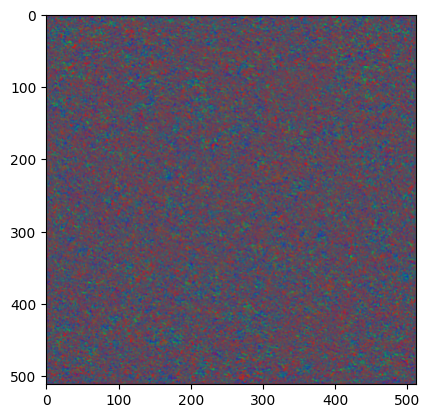

In [274]:
plt.imshow(o.squeeze(0).permute(1,2,0).detach().numpy())

In [279]:
SMOOTH = 1e-6

def iou_pytorch(outputs: torch.Tensor, labels: torch.Tensor):
    # You can comment out this line if you are passing tensors of equal shape
    # But if you are passing output from UNet or something it will most probably
    # be with the BATCH x 1 x H x W shape
    #outputs = outputs.squeeze(1)  # BATCH x 1 x H x W => BATCH x H x W
    
    intersection = (outputs & labels).float().sum((1, 2))  # Will be zero if Truth=0 or Prediction=0
    union = (outputs | labels).float().sum((1, 2))         # Will be zzero if both are 0
    
    iou = (intersection + SMOOTH) / (union + SMOOTH)  # We smooth our devision to avoid 0/0
    
    thresholded = torch.clamp(20 * (iou - 0.5), 0, 10).ceil() / 10  # This is equal to comparing with thresolds
    
    return thresholded  # Or thresholded.mean() if you are interested in average across the batch

In [276]:
loss = 

In [277]:
image = torch.randn(1,3,512,512)
out = u(image)

torch.Size([1, 3, 512, 512])
torch.Size([1, 16, 512, 512])
torch.Size([1, 32, 512, 512])


In [287]:
loss = iou_loss(out,image)

In [288]:
loss

tensor(0.9984, grad_fn=<RsubBackward1>)

In [289]:
loss.backward()

In [290]:
loss

tensor(0.9984, grad_fn=<RsubBackward1>)

In [291]:
import torch.optim as optim

In [292]:
optimizer = optim.Adam(u.parameters())

In [293]:
optimizer.step()

In [294]:
loss

tensor(0.9984, grad_fn=<RsubBackward1>)

In [281]:
def mean_iou_loss(pred, target, num_classes, smooth=1e-6):
    # Apply softmax to the predictions along the channel dimension
    pred = F.softmax(pred, dim=1)
    
    iou_per_class = []
    for cls in range(num_classes):
        # Create binary mask for each class
        pred_class = pred[:, cls, :, :]
        target_class = (target == cls).float()
        
        # Flatten predictions and target to compute intersection and union
        pred_class = pred_class.view(-1)
        target_class = target_class.view(-1)
        
        # Calculate intersection and union for this class
        intersection = (pred_class * target_class).sum()
        union = pred_class.sum() + target_class.sum() - intersection
        
        # Compute IoU for this class
        iou = (intersection + smooth) / (union + smooth)
        iou_per_class.append(iou)
    
    # Mean IoU across all classes
    mean_iou = torch.mean(torch.stack(iou_per_class))
    
    # Mean IoU loss
    return 1 - mean_iou

# Example usage
pred = torch.randn(1, 3, 256, 256)  # Raw model predictions (logits) for 3 classes
target = torch.randint(0, 3, (1, 256, 256))  # Ground truth mask with class labels
loss = mean_iou_loss(pred, target, num_classes=3)
print(f"Mean IoU Loss (Multi-Class): {loss.item()}")


Mean IoU Loss (Multi-Class): 0.7997138500213623


In [283]:
image.shape,out.shape

(torch.Size([1, 3, 512, 512]), torch.Size([1, 3, 512, 512]))

In [286]:
import torch
import torch.nn.functional as F

def iou_loss(pred, target, smooth=1e-6):
    # Apply sigmoid to the predictions (assuming raw logits as input)
    pred = torch.sigmoid(pred)
    
    # Flatten predictions and target to compute intersection and union
    pred = pred.view(-1)
    target = target.view(-1)
    
    # Calculate intersection and union
    intersection = (pred * target).sum()
    union = pred.sum() + target.sum() - intersection
    
    # Compute IoU
    iou = (intersection + smooth) / (union + smooth)
    
    # IoU loss
    return 1 - iou

# Example usage
pred = torch.randn(1, 1, 256, 256)  # Raw model predictions (logits)
target = torch.randint(0, 2, (1, 1, 256, 256)).float()  # Ground truth binary mask
loss = iou_loss(pred, target)
print(f"IoU Loss (Binary): {loss.item()}")


IoU Loss (Binary): 0.6652960181236267


In [22]:
class BNET(nn.Module):
    def __init__(self):
        super().__init__()
        self.enc_l1_conv = nn.Conv2d(1,64,(7,7),stride=2,padding=3)
        self.bn_64 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.res_block_downsample_l2 = res_block_downsampling(64,64)
        self.residual_basic_block_l2 = residual_basic_block(64,64)
        self.res_block_downsample_l3 = res_block_downsampling(64,128)
        self.res_basic_block_l3 = residual_basic_block(128,128)
        self.res_block_downsample_l4 = res_block_downsampling(128,256)
        self.res_basic_block_l4 = residual_basic_block(256,256)
        self.res_block_downsample_l5 = res_block_downsampling(256,512)
        self.res_basic_block_l5 = residual_basic_block(512,512)
        self.upsample = nn.Upsample(scale_factor=2,mode='bilinear',align_corners=True)
        self.dconv_l1 = double_conv(768,256)
        self.dec_head_l1 = dec_head(256,3)
        self.dconv_l2 = double_conv(384,128)
        self.dec_head_l2 = dec_head(128,3)
        self.dconv_l3 = double_conv(192,64)
        self.dec_head_l3 = dec_head(64,3)
        self.dconv_l4 = double_conv(128,32)
        self.dec_head_l4 = dec_head(32,3)
        self.dconv_l5 = double_conv(32,16)
        self.dec_head_l5 = dec_head(16,3)
    def forward(self,im): #im = 3*512*512
        enc_im_out_l1 = self.relu(self.bn_64(self.enc_l1_conv(im)))  #(64,256,256)
        enc_im_l2_ds = self.res_block_downsample_l2(enc_im_out_l1)
        enc_im_l2_1 = self.residual_basic_block_l2(enc_im_l2_ds)
        enc_im_l2_out = self.residual_basic_block_l2(enc_im_l2_ds)
        enc_im_l3_ds = self.res_block_downsample_l3(enc_im_l2_out)
        enc_im_l3_1 = self.res_basic_block_l3(enc_im_l3_ds)
        enc_im_l3_2 = self.res_basic_block_l3(enc_im_l3_1)
        enc_im_l3_out = self.res_basic_block_l3(enc_im_l3_2)
        enc_im_l4_ds = self.res_block_downsample_l4(enc_im_l3_out)
        enc_im_l4_1 = self.res_basic_block_l4(enc_im_l4_ds)
        enc_im_l4_2 = self.res_basic_block_l4(enc_im_l4_1)
        enc_im_l4_3 = self.res_basic_block_l4(enc_im_l4_2)
        enc_im_l4_4 = self.res_basic_block_l4(enc_im_l4_3)
        enc_im_l4_out = self.res_basic_block_l4(enc_im_l4_4)
        enc_im_l5_ds = self.res_block_downsample_l5(enc_im_l4_out)
        enc_im_l5_1 = self.res_basic_block_l5(enc_im_l5_ds)
        enc_im_l5_out = self.res_basic_block_l5(enc_im_l5_1)
        dec_l1_bl_inp = self.upsample(enc_im_l5_out)
        dec_l1_inp = torch.cat([enc_im_l4_out,dec_l1_bl_inp],dim=1)
        dec_l1_out = self.dconv_l1(dec_l1_inp)
        dec_l1_fmap = self.dec_head_l1(dec_l1_out)
        dec_l2_bl_inp = self.upsample(dec_l1_out)
        dec_l2_inp = torch.cat([enc_im_l3_out,dec_l2_bl_inp],dim=1)
        dec_l2_out = self.dconv_l2(dec_l2_inp)
        dec_l2_fmap = self.dec_head_l2(dec_l2_out)
        dec_l3_bl_inp = self.upsample(dec_l2_out)
        dec_l3_inp = torch.cat([enc_im_l2_out,dec_l3_bl_inp],dim=1)
        dec_l3_out = self.dconv_l3(dec_l3_inp)
        dec_l3_fmap = self.dec_head_l3(dec_l3_out)
        dec_l4_bl_inp = self.upsample(dec_l3_out)
        dec_l4_inp = torch.cat([enc_im_out_l1,dec_l4_bl_inp],dim=1)
        dec_l4_out = self.dconv_l4(dec_l4_inp)
        dec_l4_fmap = self.dec_head_l4(dec_l4_out)
        dec_l5_inp = self.upsample(dec_l4_out)
        dec_l5_out = self.dconv_l5(dec_l5_inp)
        dec_l5_fmap = self.dec_head_l5(dec_l5_out)
        print(dec_l5_fmap.shape)
        print(dec_l5_out.shape)
        print(dec_l5_inp.shape)
        return dec_l5_fmap

In [23]:
b = BNET()

In [24]:
o = b(torch.randn(1,1,512,512))

torch.Size([1, 3, 512, 512])
torch.Size([1, 16, 512, 512])
torch.Size([1, 32, 512, 512])


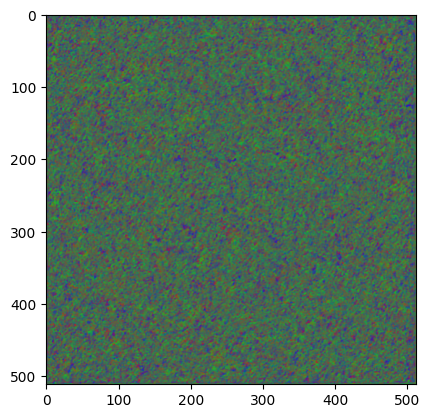

In [26]:
plt.imshow(o.squeeze(0).permute(1,2,0).detach().numpy())

In [29]:
oe = b(te.unsqueeze(0).unsqueeze(1))

torch.Size([1, 3, 512, 512])
torch.Size([1, 16, 512, 512])
torch.Size([1, 32, 512, 512])


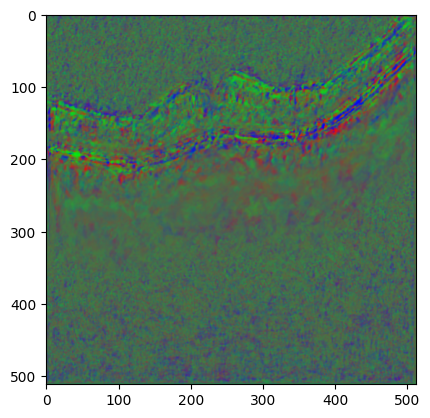

In [33]:
plt.imshow(oe.squeeze(0).permute(1,2,0).detach().numpy())

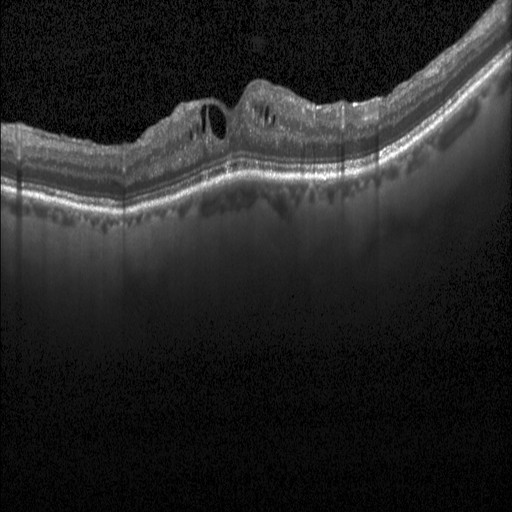

In [34]:
img